In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
import pathlib
from pathlib import Path

PROJECT_ROOT = pathlib.Path().cwd().parent
sys.path.append(str(PROJECT_ROOT))

from src.aggregation.settings import Config
from src.aggregation.utils import Network, Results, FineNetwork, CoarseNetwork, haversine_matrix
from src.aggregation.models import SpatialAggregation, TemporalAggregation
from src.aggregation.pipeline import StaticPreprocessor, DynamicProcessor
from src.gtep.pipeline import run_aggregated, run_spatial, run_temporal, consume, run_experiment
from src.gtep.types import RunArtifacts
from src.gtep.utils import ensure_unique

import pickle
import xarray as xr
import numpy as np
from numba import njit, prange
import pandas as pd
import matplotlib.pyplot as plt
import time
import gurobipy as gp
from gurobipy import GRB
import json
from dataclasses import asdict
import hashlib
import seaborn as sns
import re

def load_aggregation_pickle(path):
    pathlib.PosixPath = pathlib.WindowsPath
    with open(path, "rb") as f:
        return pickle.load(f)


In [5]:
EXP_DIR = PROJECT_ROOT / "experiments" / "exp01_features"
weight_path = EXP_DIR / "enriched_weight_grid.csv"
manifest_N5_path = EXP_DIR / "manifest_N5_grid.csv"
manifest_N10_path = EXP_DIR / "manifest_N10_grid.csv"
manifest_N15_path = EXP_DIR / "manifest_N15_grid.csv"
weight_df = pd.read_csv(weight_path)
manifest_N5_df = pd.read_csv(manifest_N5_path)
manifest_N10_df = pd.read_csv(manifest_N10_path)
manifest_N15_df = pd.read_csv(manifest_N15_path)

In [ ]:
manifest_df = pd.concat([manifest_N5_df, manifest_N10_df, manifest_N15_df], ignore_index=True)

In [11]:
df = manifest_df[manifest_df["stage"] == "temporal"].copy()
df[["N", "K"]] = df["config"].str.extract(r"N(?P<N>\d+)_K(?P<K>\d+)").astype(int)

objectives = df.apply(load_objectives, axis=1)
df = pd.concat([df, objectives], axis=1)

In [26]:
def rename_R_extra(val):
    match = re.match(r"R_extra(\d+)", str(val))
    if match:
        new_index = int(match.group(1)) + 6
        return f"R{new_index}"
    return val

df["id"] = df["id"].apply(rename_R_extra)

print(df["id"].unique())

['P5' 'T2' 'E1' 'E2' 'P1' 'E5' 'E6' 'P3' 'P4' 'P2' 'T3' 'E3' 'Spoti1'
 'Spoti2' 'E4' 'S2tiin2' 'Spoti3' 'S2tiin1' 'T1' 'S2tiin3' 'P6' 'B0' 'R6'
 'R2' 'T5' 'R5' 'R9' 'R11' 'R12' 'R1' 'R3' 'R16' 'R7' 'R10' 'T4' 'R18'
 'R15' 'R13' 'R17' 'R23' 'R4' 'R14' 'R25' 'R19' 'R20' 'R21' 'R26' 'R8'
 'R22' 'R24']


/tmp/ipykernel_8903/1603685682.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["id"] = df["id"].apply(rename_R_extra)


In [ ]:
evaluated_pairs = df.groupby("id")[["N", "K"]].apply(lambda g: set(map(tuple, g.values)))

In [15]:
from functools import reduce
common_nk_pairs = reduce(set.intersection, evaluated_pairs)
common_nk_pairs

{(5, 7), (5, 14), (5, 21), (10, 7), (10, 14), (10, 21)}

In [ ]:
# 3. Filter df to only keep rows whose (N, K) is in the common set
df = df[df[["N", "K"]].apply(tuple, axis=1).isin(common_nk_pairs)]

# 1. Rank every config within each (N, K) group
df["rank"] = df.groupby(["N", "K"])["objective"].rank(method="min")

# 2. Define score function: top-1=1.0, top-2=0.8, ..., else 0
rank_scores = {1: 1.0, 2: 0.8, 3: 0.6, 4: 0.4, 5: 0.2}
df["score"] = df["rank"].apply(lambda r: rank_scores.get(int(r), 0.0))

# 3. Compute relative gap to group best
best_obj = df.groupby(["N", "K"])["objective"].transform("min")
df["rel_gap"] = (df["objective"] - best_obj) / best_obj

# 4. Now aggregate over *all* (N,K) evaluations
summary_all = (
    df.groupby("id")
    .agg(
        num_runs    = ("objective", "count"),
        mean_rank   = ("rank", "mean"),
        mean_score  = ("score", "mean"),
        total_score = ("score", "sum"),
        mean_gap    = ("rel_gap", "mean"),
        std_gap     = ("rel_gap", "std"),
    )
    .round(3)
    .sort_values("mean_score", ascending=False)
)

print(summary_all)


/tmp/ipykernel_8903/639935683.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top5 = df.groupby(["N", "K"], group_keys=False).apply(lambda g: g.nsmallest(5, "objective")).copy()


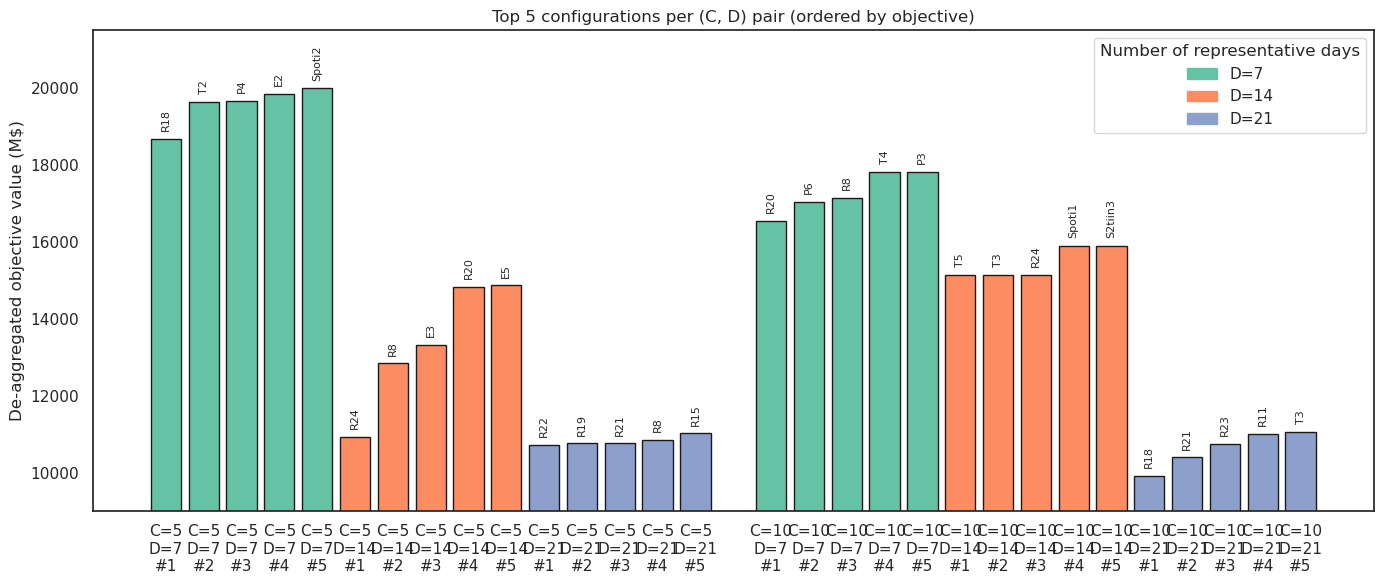

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.patches as mpatches

# Recompute top 5 per (N, K)
top5 = df.groupby(["N", "K"], group_keys=False).apply(lambda g: g.nsmallest(5, "objective")).copy()
top5 = top5.sort_values(["N", "K", "objective"])

# Add rank within each (N, K)
top5["rank_within_group"] = top5.groupby(["N", "K"]).cumcount()
top5["x_label"] = top5.apply(lambda row: f"C={row['N']}\nD={row['K']}\n#{row['rank_within_group']+1}", axis=1)

# Color by D
palette = sns.color_palette("Set2", n_colors=top5["K"].nunique())
color_map = {k: palette[i] for i, k in enumerate(sorted(top5["K"].unique()))}
top5["color"] = top5["K"].map(color_map)

# Insert spacers between different values of N
spaced_rows = []
prev_N = None

for _, row in top5.iterrows():
    curr_N = row["N"]
    if prev_N is not None and curr_N != prev_N:
        # Insert a spacer row with required columns
        spacer = {
            "x_label": " ",         # Blank x-axis label
            "objective": float("nan"),
            "color": "white",
            "id": ""
        }
        spaced_rows.append(spacer)

    # Append row as a dict (not as Series)
    spaced_rows.append(row.to_dict())
    prev_N = curr_N

# Now build DataFrame safely
plot_df = pd.DataFrame(spaced_rows)


# Plot
plt.figure(figsize=(14, 6))
bars = plt.bar(plot_df["x_label"], plot_df["objective"], color=plot_df["color"], edgecolor='k')

# Annotate bars with IDs
for bar, id_ in zip(bars, plot_df["id"]):
    if id_ != "":
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.01 * plot_df["objective"].max(), id_,
                 ha='center', va='bottom', fontsize=8, rotation=90)

# Axis and legend
plt.ylabel("De-aggregated objective value (M$)")
plt.title("Top 5 configurations per (C, D) pair (ordered by objective)")
plt.xticks(rotation=0)
plt.tight_layout()

# Legend for D
handles = [mpatches.Patch(color=color_map[k], label=f"D={k}") for k in sorted(color_map)]
# plt.legend(handles=handles, title="Number of representative days", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.legend(handles=handles, title="Number of representative days", loc="upper right", frameon=True)


plt.ylim(9000, 21500)
plt.savefig(PROJECT_ROOT / 'figs' / 'top5_barplot.png', dpi=300, bbox_inches='tight')
plt.show()


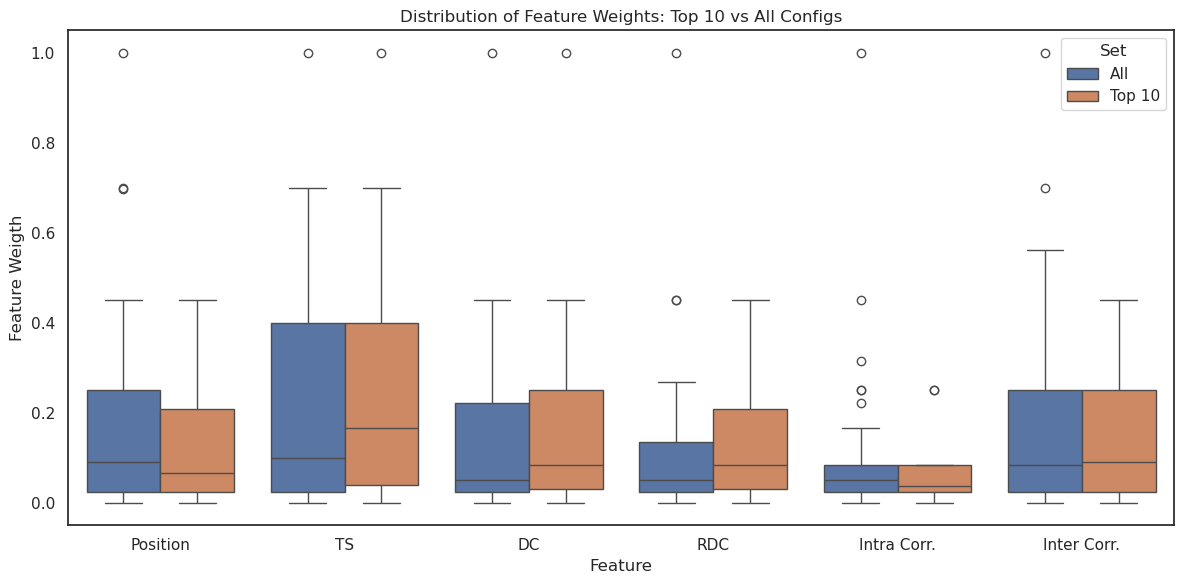

In [64]:
# ─── Load and Merge ─────────────────────────────────────────────────────────────
summary = summary_all.copy()  # résumé avec scores
weights = weight_df.copy()    # poids des features par id
df = summary.merge(weights, on="id")

# ─── Sélection du Top 10 ────────────────────────────────────────────────────────
top = df.sort_values("total_score", ascending=False).head(10)
features = [c for c in weights.columns if c not in ['id', 'desc']]

# ─── Construction du DataFrame pour le Boxplot ──────────────────────────────────
df_long = pd.melt(df[['id'] + features], id_vars='id', var_name='feature', value_name='weight')
df_long['Set'] = 'All'

top_long = pd.melt(top[['id'] + features], id_vars='id', var_name='feature', value_name='weight')
top_long['Set'] = 'Top 10'

combined = pd.concat([df_long, top_long])

# Rename feature labels for display
rename_map = {
    "position": "Position",
    "time_series": "TS",
    "duration_curves": "DC",
    "ramp_duration_curves": "RDC",
    "intra_correlation": "Intra Corr.",
    "inter_correlation": "Inter Corr."
}

combined["feature"] = combined["feature"].replace(rename_map)


# ─── Boxplot ─────────────────────────────────────────────────────────────────────
plt.figure(figsize=(12, 6))
sns.boxplot(data=combined, x='feature', y='weight', hue='Set')
plt.title("Distribution of Feature Weights: Top 10 vs All Configs")
plt.ylabel("Feature Weigth")
plt.xlabel("Feature")
# plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(PROJECT_ROOT / 'figs' / 'features_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()


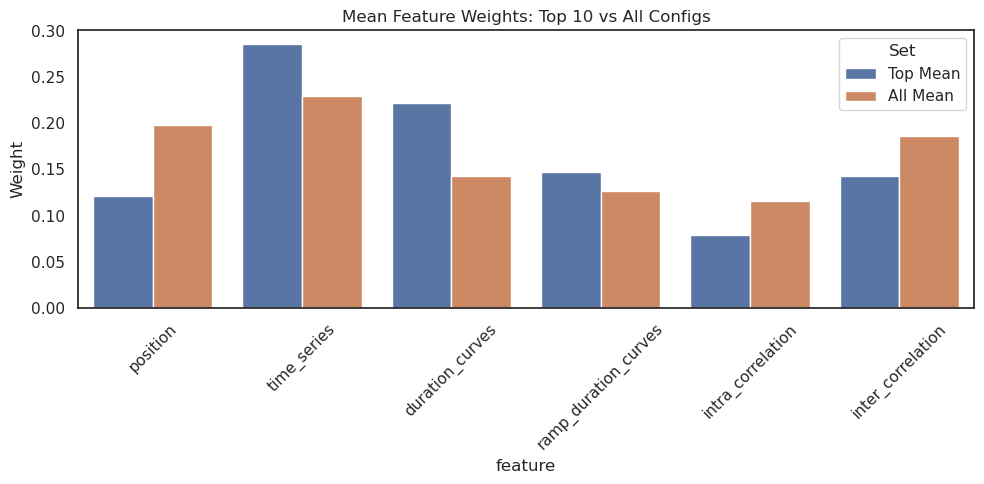

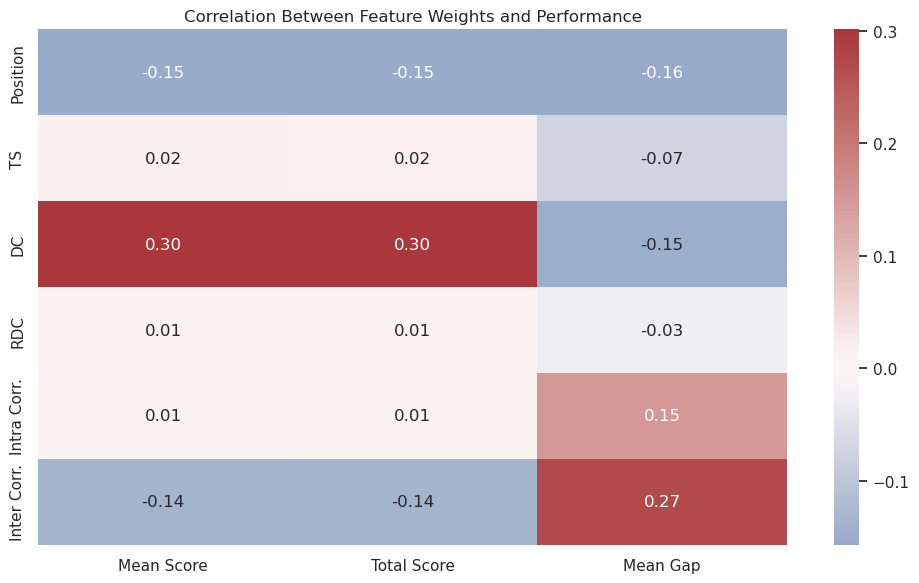

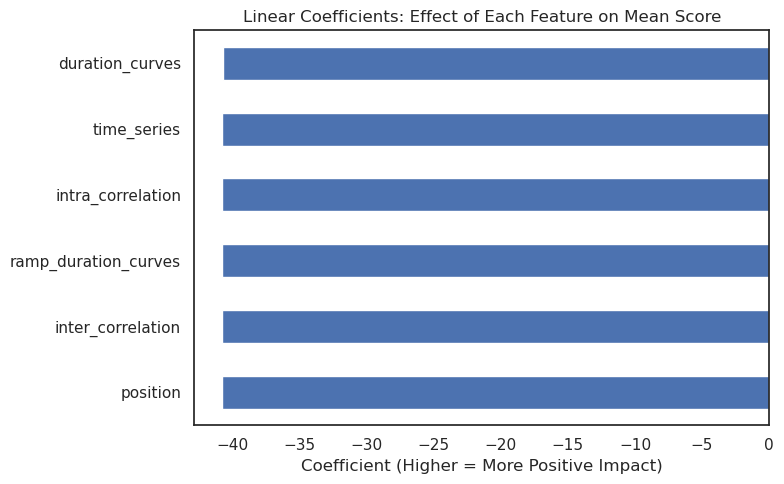

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ─── Load Your Data ─────────────────────────────────────────────────────────────
summary = summary_all.copy()  # Use the summary from above
weights = weight_df.copy()  # already uploaded

# Merge the weights into the summary (by id)
df = summary.merge(weights, on="id")

# ─── Select the Best Performing Configurations ──────────────────────────────────
# For example, top 10 by total_score or mean_score
top = df.sort_values("total_score", ascending=False).head(10)


# ─── Correlation Between Feature Weights and Performance ────────────────────────
corrs = df[features + ["mean_score", "total_score", "mean_gap"]].corr()

feature_rename = {
    "position": "Position",
    "time_series": "TS",
    "duration_curves": "DC",
    "ramp_duration_curves": "RDC",
    "intra_correlation": "Intra Corr.",
    "inter_correlation": "Inter Corr."
}

perf_rename = {
    "mean_score": "Mean Score",
    "total_score": "Total Score",
    "mean_gap": "Mean Gap"
}

# Apply renaming to rows and columns
corrs_renamed = corrs.rename(index=feature_rename, columns=perf_rename)

# Features might not all be renamed, so fall back to original names
rows = [feature_rename.get(f, f) for f in features]
cols = list(perf_rename.values())

# Plot
plt.figure(figsize=(10, 6))
sns.heatmap(corrs_renamed.loc[rows, cols], annot=True, cmap="vlag", center=0, fmt=".2f")
plt.title("Correlation Between Feature Weights and Performance")
plt.tight_layout()
plt.savefig(PROJECT_ROOT / 'figs' / 'features_corr.png', dpi=300, bbox_inches='tight')
plt.show()
